# Latency Scatter

In [202]:
import quail
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import pearsonr
import numpy as np

%matplotlib inline
sns.set_context("notebook", font_scale=1.5)

# Import Data

In [203]:
# transcription 
auto_words = quail.load_egg('../data/auto_egg.egg')
man_words = quail.load_egg('../data/man_egg.egg')

In [204]:
auto_words

In [205]:
# onsets
with open('../data/automatic_onsets_NEW.p', 'rb') as file:
    auto_onsets = pickle.load(file)
    
with open('../data/manual_onsets_NEW.p', 'rb') as file:
    man_onsets = pickle.load(file)
    

In [206]:
array1 = []

for x in range(0,30):
    array1.append([x]*8)
    
array2 = []
for y in range(0,30):
    array2.append([0,1,2,3,4,5,6,7])
    
array1= [val for sublist in array1 for val in sublist]
array2 = [val for sublist in array2 for val in sublist]

arrays = [array1, array2]
tuples = list(zip(arrays))

index = pd.MultiIndex.from_tuples(tuples, names = [''])

TypeError: unhashable type: 'list'

In [207]:
tuples

[([0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   9,
   9,
   9,
   9,
   9,
   9,
   9,
   9,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   12,
   12,
   12,
   12,
   12,
   12,
   12,
   12,
   13,
   13,
   13,
   13,
   13,
   13,
   13,
   13,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   15,
   15,
   15,
   15,
   15,
   15,
   15,
   15,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   17,
   17,
   17,
   17,
   17,
   17,
   17,
   17,
   18,
   18,
   18,
   18,
   18,
   18,
   18,
   18,
   19,
   19,
  

In [208]:
auto_onsets.reindex(index=index)

NameError: name 'index' is not defined

In [209]:
man_onsets.loc[0]

,List,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Subject,,,,,,,,,,,,,,,,,,
0,0,807.755102,3175.170068,5387.052154,7843.537415,10613.287982,13088.707483,15822.108844,20342.312925,24593.560091,28598.344671,31336.734694,NaN,NaN,NaN,NaN,NaN,NaN
0,1,1727.324263,4441.768707,7046.122449,11225.850340,14661.723356,17896.870748,20992.108844,24144.467120,28004.535147,33750.702948,36902.653061,44921.22449,60159.954649,NaN,NaN,NaN,NaN
0,2,1724.126984,3362.199546,6222.675737,9689.841270,13224.104308,16522.312925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,1355.578231,3323.424036,6387.301587,9118.140590,16516.780045,19377.256236,29822.517007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,1369.818594,3407.324263,6117.074830,8829.977324,11380.340136,14501.337868,17735.170068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5,1148.027211,3959.501134,6961.723356,9480.430839,11981.609977,14861.746032,17721.224490,25917.596372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,6,1479.637188,3696.802721,6245.147392,8802.335601,11334.285714,14876.689342,17556.507937,20520.317460,24018.548753,28765.668934,49380.158730,NaN,NaN,NaN,NaN,NaN,NaN
0,7,1211.700680,3377.120181,5248.934240,8077.052154,10529.977324,14083.492063,29174.353741,37487.959184,49250.770975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
grouped = man_onsets.groupby(['Subject']).show()

#tips.groupby(['smoker','time']).size()

AttributeError: 'DataFrameGroupBy' object has no attribute 'show'

AttributeError: 'DataFrameGroupBy' object has no attribute 'pres'

In [101]:
def get_matching_inds(x, y):
    def match_matrix(x, y):
        m = np.zeros([len(x) + 1, len(y) + 1])
        for i in np.arange(len(x)):
            for j in np.arange(len(y)):
                if x[i] == y[j]:
                    m[i+1, j+1] = m[i, j] + 1
                else:
                    m[i+1, j+1] = np.max([m[i, j+1], m[i+1, j]])
        return m
    
    def backtrack(m, x, y):
        i = len(x)
        j = len(y)
        
        longest_common_sequence = list()
        x_inds = list()
        y_inds = list()
        
        while (i >= 1) and (j >= 1):
            if m[i, j] == m[i, j-1]:
                j -= 1
            elif m[i, j] == m[i-1, j]:
                i -= 1                
            else:
                i -= 1
                j -= 1
                longest_common_sequence.insert(0, x[i])
                x_inds.insert(0, i)
                y_inds.insert(0, j)
        return longest_common_sequence, x_inds, y_inds
    
    return backtrack(match_matrix(x, y), x, y)

# Onset Data

# Replace Nones with Nans

In [102]:
from numpy import nan
man_words.rec.fillna(value=nan, inplace=True)
auto_words.rec.fillna(value=nan, inplace=True)
man_onsets.fillna(value=nan, inplace=True)
auto_onsets.fillna(value=nan, inplace=True)

In [103]:
type(man)

list

# Obtain Onsets

In [104]:
x_onsets = []
y_onsets = []
list_corrs = []
sub_corrs = []

for sub in range(30):
    
    # subject-wise variables
    sub_lists_man = []
    sub_lists_auto = []
    
    for lst in range(8):

        # get man and auto words for this list
        man = list(man_words.rec.loc[sub].iloc[lst])
        auto = list(auto_words.rec.loc[sub].iloc[lst])
        
        # get the string and indices
        data = get_matching_inds(man, auto)
        
        # assign man and auto indices
        mo_ind = data[1]
        ao_ind = data[2]
        
        # generate list-wise correlations
        mo_list = [float(list(man_onsets.loc[sub].iloc[lst])[mo]) for mo in mo_ind]
        ao_list = [float(list(auto_onsets.loc[sub].iloc[lst])[ao]) for ao in ao_ind]
        list_corrs.append(pearsonr(mo_list, ao_list))
        
        # pull corr values out of tuple
        list_corrs_only = [x[0] for x in list_corrs]
        
        # generat subject-wise correlations
        sub_lists_man.append(mo_list)
        sub_lists_auto.append(ao_list)
        
        # get individual onset vals for all words, all subs, all lists 
        for mo,ao in zip(mo_ind, ao_ind):
            
            x_onsets.append(float(list(man_onsets.loc[sub].iloc[lst])[mo])*.001)
            y_onsets.append(float(list(auto_onsets.loc[sub].iloc[lst])[ao]))
            
    flat_man_lists = [item for sublist in sub_lists_man for item in sublist]
    flat_auto_lists = [item for sublist in sub_lists_auto for item in sublist]
    sub_corrs.append(pearsonr(flat_man_lists, flat_auto_lists))
        
    # pull corr values out of tuple
    sub_corrs_only = [x[0] for x in sub_corrs]

# Onset Correlation - By List

<a list of 99 Patch objects>

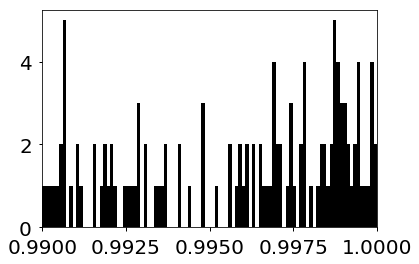

In [105]:
plt.xlim(.990, 1)

plt.hist(list_corrs_only, color='black', range=[.90, 1.00], bins=list(np.linspace(.99,1.00,100)))[2]


# Onset Correlation - By Word

<a list of 99 Patch objects>

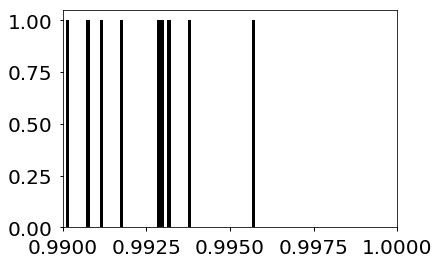

In [106]:
plt.xlim(.990, 1)
g = np.linspace(.99,1.00,100)

plt.hist(sub_corrs_only, color='black', range=[.90, 1.00], bins=list(g))[2]

(0.9871519244840596, 0.0)


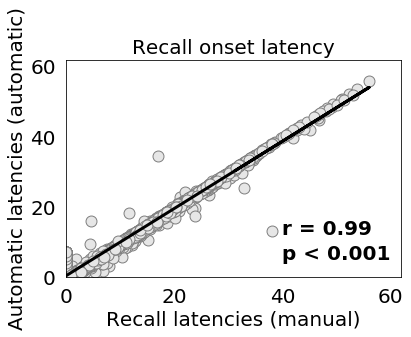

In [107]:
fig = plt.figure(2)
ax = fig.add_subplot(111)#, axisbg='white')
ax.scatter(x_onsets, y_onsets, facecolor='.9', linewidth=1, color='gray', s=120)#, linewidth=2.0)
plt.grid(False)

plt.axis([0, 62, 0, 62])
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.xlabel('Recall latencies (manual)', fontsize=20)
plt.ylabel('Automatic latencies (automatic)', fontsize=20)

reg_line = np.polyfit(x_onsets, y_onsets, 1)
plt.plot(x_onsets, np.poly1d(reg_line)(x_onsets), color='black', linewidth=3.0)

from scipy.stats import pearsonr
r = pearsonr(x_onsets, y_onsets)

plt.title('Recall onset latency', fontsize=20)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.text(40, 12, 'r = ' + str(0.99), fontsize=20, fontweight='bold')
plt.text(40, 5, 'p < ' + str(0.001), fontsize=20, fontweight='bold')

print r